In [1]:
# FedAvg
# FedFair
# data distribution that we used

# Recall
# FedAvg + FairFed + normal model

# Plots withing notbooks
# Plots for Acc vs subGroup
# Show data distrubution
# Recall of positive class
# the data split we use....

In [1]:
import pandas as pd
import time
import numpy as np
import copy
import glob
import sys, os
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from sklearn.metrics import precision_score, recall_score
import pickle
from sklearn import preprocessing
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from folktables import ACSDataSource, ACSEmployment,ACSIncome
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import os
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F
import pandas as pd
from scipy.stats import multivariate_normal
import torch, random, copy, os
from collections import OrderedDict


In [2]:
# TPR
# Gender: 
# 1: Male, 0: Female
# Fairness: Male- Female
# eq-4: Global- TPR

# Fk = 

In [3]:
# !pip install ray

# data preparation

In [4]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
else:
    # CUDA is not available
    print("CUDA is not available. Running on CPU.")


CUDA is available.


In [5]:
os.getcwd()

'/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB'

In [6]:
 
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 14 : input shape
        # 9-> we have 9 columns in data 
        self.layer1 = nn.Linear(14, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x



# assigning Models

In [7]:
#create global model and client models
temp_model = DeepNet()
# path="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/global_model_2.pt"
path="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/global_model.pt"
print("global_model::: FedAVG")
print("global_model_2:: FairFair")
torch.save(temp_model.state_dict(), path)

# this has to be same in follwing code as well
selected_clients=[0,1,2,3]

for client_id in selected_clients:
    client_model_path = f"/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/client_{client_id}_model.pth"
    torch.save(temp_model.state_dict(), client_model_path)
    


global_model::: FedAVG
global_model_2:: FairFair


In [8]:

class Client:
    def __init__(self):
        self.client_id: int = None
        self.valset: DataLoader = None
        self.trainset: DataLoader = None
        self.testset: DataLoader = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")         
        self.model = DeepNet().to(self.device)
        self.criterion = torch.nn.BCELoss()

        self.fainess_score=0

        self.info_collection=[]
        self.client_df = pd.DataFrame()
        self.selected_clients=[0,1,2,3]
        
    def get_client_local_dataset(self):
                
        temp_path_data="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/data_fairFed"
        
        with open(temp_path_data+"/clients_training.pkl", "rb") as f:
            self.trainset = pickle.load(f)
            
        with open(temp_path_data+"/clients_validation.pkl", "rb") as f:
            self.valset = pickle.load(f)
         
        with open(temp_path_data+"/clients_testing_wrong.pkl", "rb") as f:
            self.testset  = pickle.load(f)

        self.trainset = self.trainset[self.client_id]
        self.valset = self.valset[self.client_id]       
        self.testset = self.testset[self.client_id]

    def calculate_fairness(self,y_hat, A, Y):
        # Calculate counts using torch.sum
        y_hat, A, Y = y_hat.to(self.device), A.to(self.device), Y.to(self.device)

        # 1: Male, 0: Female
        predict_Y_male = torch.sum((y_hat[(A == 1) & (Y == 1)] == 1)).item()
        predict_Y_female = torch.sum((y_hat[(A == 0) & (Y == 1)] == 1)).item()
        
        count_Y_male = torch.sum((Y[(A == 1) & (Y == 1)] == 1)).item()
        count_Y_female = torch.sum((Y[(A == 0) & (Y == 1)] == 1)).item()
    
        # Calculate probabilities
        prob_Y_male = predict_Y_male / count_Y_male if count_Y_male > 0 else 0
        prob_Y_female = predict_Y_female / count_Y_female if count_Y_female > 0 else 0
    
        # Calculate Fglobal
        fairness_score = prob_Y_male - prob_Y_female
        
        return  fairness_score

    def train(self, client_id: int, model_path, num_epochs=5, learning_rate=0.001):
        self.client_id = client_id
        self.get_client_local_dataset()

        # Define loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.fainess_score=0
      
        self.model.load_state_dict(torch.load(model_path,map_location=self.device))
        for epoch in range(num_epochs):
            # Set the model to training mode
            self.model.train()

            for inputs, labels, sens in self.trainset:
                
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs).to(self.device)
                loss = self.criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()

            # Calculate and print the training accuracy for this epoch (optional)
            correct = 0
            total = 0
            size = 0
            loss = 0
            correct = 0
            total = 0
            predicted_labels = []
            true_labels = []
            final_fairness=[]
            
            with torch.no_grad():
                print("======Validation========")
                for inputs, labels,sens in self.valset:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    
                    outputs = self.model(inputs)
                    loss += self.criterion(outputs, labels)
                    predicted = outputs > 0.5

                    predicted_labels.extend(predicted.cpu().numpy())
                    true_labels.extend(labels.cpu().numpy())

                    fairNess_per_batch=self.calculate_fairness(torch.round(outputs).squeeze(), sens.squeeze(), labels.squeeze())
                    final_fairness.append(fairNess_per_batch)
                    self.fainess_score=np.mean(final_fairness)

                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            loss = loss / len(self.valset)        
            acc = correct / total

            precision = precision_score(true_labels, predicted_labels,zero_division=0.0)            
            recall = recall_score(true_labels, predicted_labels)
            
            # accuracy = 100 * correct / total
            # print(f"Epoch {epoch+1}/{num_epochs}, Training Accuracy: {acc:.5f}%")
            print(f"Epoch {epoch+1}/{num_epochs}, Training Fairness: {self.fainess_score:.5f}%")

        # Optionally, save the trained model parameters
        client_model_path = f"/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/client_{self.client_id}_model.pth"
        torch.save(self.model.state_dict(), client_model_path)

        # Return the trained model parameters
        return list(self.model.state_dict().values()), len(self.trainset.dataset),self.model.state_dict(), self.fainess_score

    @torch.no_grad()
    def client_evaluate(self, val=False):
        
        size = 0
        loss = 0
        correct = 0
        total = 0
        predicted_labels = []
        true_labels = []

        
        models_directory = "/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/"
                 
        for client_id in self.selected_clients:
            
            print("===============Testing======================")
            # print(" selected client for Testing:: ", client_id)
            model_path = os.path.join(models_directory, f"client_{client_id}_model.pth")            
        
            self.model.load_state_dict(torch.load(model_path,map_location=self.device))

            self.model.eval()

            for inputs, targets,sens in self.testset:
                
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                
                outputs = self.model(inputs)
                loss += self.criterion(outputs, targets)
                predicted = outputs > 0.5
                
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(targets.cpu().numpy())
                
                total += targets.size(0)
                correct += (predicted == targets).sum().item()                
            
            loss = loss / len(self.testset)
            acc = correct / total
            
            # print("loss: %f\n" % (loss))
            
            
            print(f" Client Accuracy: {acc:.5%}")
    #         print(predicted_labels," :: ",true_labels)
            precision = precision_score(true_labels, predicted_labels,zero_division=0.0)
            
            recall = recall_score(true_labels, predicted_labels)
    
            print(f" Client Precision: {precision:.5%}")
            print(f" Client Recall: {recall:.5%}")
            
            print("\n\n")
            
        return loss, acc,precision,recall

    
    @torch.no_grad()
    def server_evaluate(self):

        # print("Global Model testing Starts")
        # print("kindly check the Path. Select it based on FedAvg Model")
        # print("warning: Test data has already been used")
        
        path="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/global_model.pt"
        # path="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/global_model_2.pt"
        
        self.model.load_state_dict(torch.load(path,map_location=self.device))
        self.model.eval()
        size = 0
        loss = 0
        correct = 0
        total = 0
        predicted_labels = []
        true_labels = []
        final_fairness=[]
        for inputs, targets,sens in self.testset:
            
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            outputs = self.model(inputs)
            loss += self.criterion(outputs, targets)
            predicted = outputs > 0.5

            fairNess_per_batch=self.calculate_fairness(torch.round(outputs).squeeze(), sens.squeeze(), targets.squeeze())
            final_fairness.append(fairNess_per_batch)
            fairness_global=np.mean(final_fairness)
            
#            print("predicted",predicted)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
        
        loss = loss / len(self.testset)
        acc = correct / total
        
        # print("loss: %f\n" % (loss))
        
        print(f"Global Testing Accuracy: {acc:.5%}")
        print(f" Global Fairness: {fairness_global:.5f}%")
        precision = precision_score(true_labels, predicted_labels,zero_division=0.0)
        
        recall = recall_score(true_labels, predicted_labels)
        
        print(f"Global Precision: {precision:.5%}")
        print(f"Global Recall: {recall:.5%}")
        
        return loss, acc, precision, recall,fairness_global
                                            

In [9]:
class Serverbase:
    def __init__ (self,model):
        self.model = model
        self.global_model=model
        self.num_rounds=2
        self.local_epoch=2
        self.optimizer=2
        self.lr=0.001
        self.beta=0.02
        self.batch_size=32
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

        self.client_id_indices, self.client_num_in_total = [0,1], 2 
        
        self.updated_params_cache = []
        self.weights_cache = []
        self.model_dict = []
        
        self.global_params_dict: OrderedDict[str : torch.Tensor] = None

        self.backbone=DeepNet
        _dummy_model = self.backbone()
        self.global_params_dict = OrderedDict(_dummy_model.state_dict())

        self.temp_dir="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/"

        self.fair_global_t_step=0
        self.fair_local_client=0   
        
        self.acc_clients=[]
        self.clients_id=[]
        self.precision_clients=[]
        self.recall_clients=[]
        
        self.global_acc=0
        self.fairness_diff=[]
        self.clients_weights=[]
        self.final_agg_weights_clients=[]
        self.selected_clients=[0,1,2,3]
        
    def fairFed(self, num_rounds = 2, local_epochs = 2, learning_rate = 0.005, beta = 0.3, alpha = 0.1, optimizer = 'adam'):
        
        for round_ in tqdm(range(num_rounds)):
  
            #each round we need empty lists
            self.updated_params_cache = []
            self.weights_cache = []
            self.model_dict=[]
            self.clients_weights=[]
            self.final_agg_weights_clients=[]
            
            for client_id in self.selected_clients:
                self.global_acc=0
                client = Client()
                print("client_id:: ",client_id)
                # weight is length of dataset

                models_directory = "/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/models/"
                model_path = os.path.join(models_directory, f"client_{client_id}_model.pth")                       
                
                updated_params_list, weight, model_dict_list,fairness_client = client.train(client_id,  model_path, num_epochs=local_epochs, learning_rate=learning_rate)
                
                loss_client, acc_client,precision_client,recall_client = client.client_evaluate(val=True)
                
                loss_client, acc_server, precision_server, recall_server,fairness_global = client.server_evaluate()
                
                # store it for SecAgg
                self.updated_params_cache.append(updated_params_list)
                self.weights_cache.append(weight)
                self.model_dict.append(model_dict_list)
                
                #store it for FairFed agg
                
                self.global_acc=acc_server
                self.fair_local_client=fairness_client
                self.fair_global=fairness_global

                # to craete df
                self.acc_clients.append(acc_client)
                self.clients_id.append(client_id)
                self.precision_clients.append(precision_client)
                self.recall_clients.append(recall_client)
        
            # self.aggregate_parameters_FedAvg(self.updated_params_cache, self.weights_cache)

            # self.aggregate_parameters_FedAvg_updated(self.model_dict)
            self.aggregate_client_weight_FedFair_part_1(self.model_dict, self.weights_cache,self.acc_clients, self.global_acc,self.fair_local_client,
                                                 self.fair_global)
            self.client_weights_update_part_2(self.clients_weights)
            # print("self.model_dict",self.model_dict)
            self.aggregate_parameters_FedAvg_updated(self.final_agg_weights_clients)
                
            # torch.save(self.global_params_dict, os.path.join(self.temp_dir, "global_model.pt"),)

        # Test Clients Models and Global Model
        # loss_client, acc_client = client.client_evaluate()        
        loss_client, accuracy_server, pre_server, recall_ser,fairness_global = client.server_evaluate()
        data = {
            'Client ID': self.clients_id,
            'Accuracy': self.acc_clients,
            'Precision': self.precision_clients,
            'Recall': self.recall_clients,
            'Accuracy_server': accuracy_server,
            'Recall_server': recall_ser,
            'Precision_server': pre_server
        }
            
        df = pd.DataFrame(data)
        df.to_csv('client_data.csv', index=False) 
        

    @torch.no_grad()
    def aggregate_parameters_FedAvg(self, updated_params_cache, weights_cache):
        weight_sum = sum(weights_cache)  
        
        weights = torch.tensor(weights_cache, device=self.device) / weight_sum
        
        aggregated_params = []

        for params in zip(*updated_params_cache):
            aggregated_params.append(
                torch.sum(weights * torch.stack(params, dim=-1), dim=-1)
            )

        self.global_params_dict = OrderedDict(
            zip(self.global_params_dict.keys(), aggregated_params)
        )

    
    @torch.no_grad()
    def aggregate_parameters_FedAvg_updated(self, model_dict_list):        
        w_avg = copy.deepcopy(model_dict_list[0])
        for k in w_avg.keys():
            for i in range(1, len(model_dict_list)):
                w_avg[k] += model_dict_list[i][k]
            w_avg[k] = torch.div(w_avg[k], len(model_dict_list))
    
        self.global_model.load_state_dict(w_avg)
        # torch.save(self.global_model.state_dict(), os.path.join(self.temp_dir, "global_model_2.pt"),)        
        torch.save(self.global_model.state_dict(), os.path.join(self.temp_dir, "global_model.pt"),)
            
    def client_weights_update_part_2(self,agg_weights):
        sum_params = OrderedDict()
        final_agg_weights_clients=[]
        for model in agg_weights:
            for name, param in model.items():
                if name in sum_params:
                    sum_params[name] += param
                else:
                    sum_params[name] = param

            updated_client_weights = OrderedDict()
            
            for name, param in model.items():
                updated_param = torch.div(param, sum_params[name])
                updated_client_weights[name] = updated_param

                self.final_agg_weights_clients.append(updated_client_weights)
                
        
    @torch.no_grad()
    def aggregate_client_weight_FedFair_part_1 (self, model_dict_list ,weights_cache, acc_clients, global_acc,fairness_client,fairness_global):
        print("len::",len(model_dict_list))
        
        if not self.fair_local_client:
            
            sum_acc_client=sum(acc_clients) /len(acc_clients)
            Delta_t_C_i= abs(sum_acc_client-global_acc)
            
        else:            
            Delta_t_C_i = abs(self.fair_global - self.fair_local_client) 
        
        for client_id in range(len(self.selected_clients)):
        
            w_avg = copy.deepcopy(model_dict_list[client_id])
            temp = copy.deepcopy(model_dict_list[client_id])
            
            for k in w_avg.keys():
                for i in range(1, len(model_dict_list)):
                    w_avg[k] += model_dict_list[i][k]
                w_avg[k] = torch.div(w_avg[k], len(model_dict_list))
                
                w_avg[k]=temp[k]-(self.beta*(Delta_t_C_i-w_avg[k]))
                
            self.clients_weights.append(w_avg)
                        
        
model = DeepNet()
server = Serverbase(model)
server.fairFed(num_rounds=2,local_epochs=2)    

  0%|                                                                                                                       | 0/2 [00:00<?, ?it/s]

client_id::  0
======Validation========
Epoch 1/10, Training Fairness: 0.75326%
======Validation========
Epoch 2/10, Training Fairness: 0.62570%
======Validation========
Epoch 3/10, Training Fairness: 0.65913%
======Validation========
Epoch 4/10, Training Fairness: 0.66426%
======Validation========
Epoch 5/10, Training Fairness: 0.72713%
======Validation========
Epoch 6/10, Training Fairness: 0.76166%
======Validation========
Epoch 7/10, Training Fairness: 0.73926%
======Validation========
Epoch 8/10, Training Fairness: 0.45841%
======Validation========
Epoch 9/10, Training Fairness: 0.61606%
======Validation========
Epoch 10/10, Training Fairness: 0.68201%
===============Testing======================
 Client Accuracy: 81.75325%
 Client Precision: 72.98851%
 Client Recall: 77.29763%



===============Testing======================
 Client Accuracy: 73.09524%
 Client Precision: 72.98851%
 Client Recall: 38.64881%



===============Testing======================
 Client Accuracy: 70.20924%

 50%|███████████████████████████████████████████████████████▌                                                       | 1/2 [01:03<01:03, 63.27s/it]

Global Testing Accuracy: 62.10394%
 Global Fairness: 0.00000%
Global Precision: 0.00000%
Global Recall: 0.00000%
len:: 4
client_id::  0
======Validation========
Epoch 1/10, Training Fairness: 0.67091%
======Validation========
Epoch 2/10, Training Fairness: 0.76649%
======Validation========
Epoch 3/10, Training Fairness: 0.71166%
======Validation========
Epoch 4/10, Training Fairness: 0.65682%
======Validation========
Epoch 5/10, Training Fairness: 0.70689%
======Validation========
Epoch 6/10, Training Fairness: 0.68725%
======Validation========
Epoch 7/10, Training Fairness: 0.59897%
======Validation========
Epoch 8/10, Training Fairness: 0.73468%
======Validation========
Epoch 9/10, Training Fairness: 0.64912%
======Validation========
Epoch 10/10, Training Fairness: 0.68935%
===============Testing======================
 Client Accuracy: 82.53247%
 Client Precision: 74.44444%
 Client Recall: 77.48022%



===============Testing======================
 Client Accuracy: 81.36364%
 Client P

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:08<00:00, 64.15s/it]

Global Testing Accuracy: 37.89606%
 Global Fairness: -1.00000%
Global Precision: 37.89606%
Global Recall: 100.00000%
len:: 4


Global Testing Accuracy: 37.89606%
 Global Fairness: -1.00000%
Global Precision: 37.89606%
Global Recall: 100.00000%


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('client_data.csv')

client_data = df[['Client ID', 'Accuracy', 'Precision', 'Recall']]
server_data = df[['Client ID', 'Accuracy_server', 'Precision_server', 'Recall_server']]


In [11]:
client_data

,Client ID,Accuracy,Precision,Recall
0,0,0.687662,0.729885,0.193244
1,1,0.707097,0.683718,0.414655
2,2,0.752816,0.812888,0.617737
3,3,0.781068,0.669188,0.835129
4,0,0.816071,0.720194,0.789562
5,1,0.797316,0.699573,0.810116
6,2,0.828196,0.842183,0.782024
7,3,0.790840,0.691192,0.809923


In [12]:
grouped = server_data.groupby(server_data.index // 4)

grouped

In [57]:
result = grouped.agg({
    "Accuracy_server": "mean",
    "Precision_server": "mean",
    "Recall_server": "mean"
}).reset_index()


In [58]:
result

,index,Accuracy_server,Precision_server,Recall_server
0,0,0.378961,0.378961,1.0
1,1,0.378961,0.378961,1.0
2,2,0.378961,0.378961,1.0
3,3,0.378961,0.378961,1.0
4,4,0.378961,0.378961,1.0


In [ ]:
# Data for the second plot (Server data)


In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'Client ID' and calculate the mean
averages = server_data.groupby('Client ID').mean()

# Take the mean of all 'Client ID' values and assign a label
average_round1 = averages.mean(axis=0)
average_round2 = averages.mean(axis=0)




In [54]:
averages

,Accuracy_server,Precision_server,Recall_server
Client ID,,,
0,0.378961,0.378961,1.0
1,0.378961,0.378961,1.0
2,0.378961,0.378961,1.0
3,0.378961,0.378961,1.0


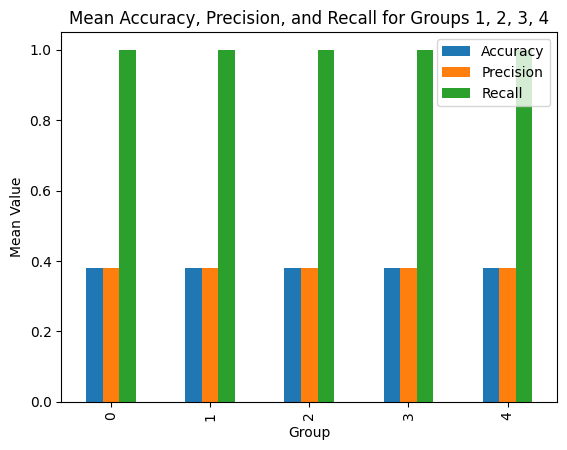

In [59]:
accuracy = client_data['Accuracy']
precision = client_data['Precision']
recall = client_data['Recall']

# Get unique client IDs for color assignment
unique_clients = client_data['Client ID'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clients)))

# Create three separate line plots with different colors for different rounds of clients
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 9))

for i, client in enumerate(unique_clients):
    client_accuracy = accuracy[client_data['Client ID'] == client]
    client_precision = precision[client_data['Client ID'] == client]
    client_recall = recall[client_data['Client ID'] == client]

    round_color = colors[i % len(colors)]  # Cycle through the color map

    ax1.plot(client_data[client_data['Client ID'] == client]['Client ID'], client_accuracy, marker='o', label=f'Client {client}', color=round_color)
    ax2.plot(client_data[client_data['Client ID'] == client]['Client ID'], client_precision, marker='x', label=f'Client {client}', color=round_color)
    ax3.plot(client_data[client_data['Client ID'] == client]['Client ID'], client_recall, marker='s', label=f'Client {client}', color=round_color)

ax1.set_ylabel('Accuracy')
ax1.set_title('Client Data: Accuracy')
ax1.legend()

ax2.set_ylabel('Precision')
ax2.set_title('Client Data: Precision')
ax2.legend()

ax3.set_xlabel('Client ID')
ax3.set_ylabel('Recall')
ax3.set_title('Client Data: Recall')
ax3.legend()

plt.tight_layout()
plt.show()